### 讀取資料

In [40]:
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

df = pd.read_excel("sources_per_article.xlsx")

# 確認欄位
print("Columns:", df.columns)

Columns: Index(['article_id', 'period', 'politicians', 'professionals', 'celebrities',
       'perpetrators', 'victims', 'other_individuals',
       'law_enforcement_agencies', 'government_bodies',
       'ngo_or_advocacy_group', 'business_entities', 'community_groups',
       'Cannot be inferred', 'not applicable', 'Individuals', 'Organizations',
       'Total', 'mainstream'],
      dtype='object')


### 定義 source type

In [42]:
source_type_cols = [
    'politicians', 'professionals', 'celebrities', 'perpetrators', 'victims',
    'other_individuals', 'law_enforcement_agencies', 'government_bodies',
    'ngo_or_advocacy_group', 'business_entities', 'community_groups'
]

individual_cols = [
    'politicians', 'professionals', 'celebrities',
    'perpetrators', 'victims', 'other_individuals'
]

organization_cols = [
    'law_enforcement_agencies', 'government_bodies',
    'ngo_or_advocacy_group', 'business_entities', 'community_groups'
]

### 分 mainstream vs non-mainstream

In [44]:
main = df[df['mainstream'] == 1]
nonmain = df[df['mainstream'] == 0]

print(f"Mainstream articles: {len(main)}")
print(f"Non-mainstream articles: {len(nonmain)}")
print("Mainstream mean sources:", main['Total'].mean())
print("Non-mainstream mean sources:", nonmain['Total'].mean())
print("Mainstream median sources:", main['Total'].median())
print("Non-mainstream median sources:", nonmain['Total'].median())

Mainstream articles: 150
Non-mainstream articles: 429
Mainstream mean sources: 12.266666666666667
Non-mainstream mean sources: 9.783216783216783
Mainstream median sources: 12.0
Non-mainstream median sources: 9.0


### Mann-Whitney U test

In [62]:
stat, p = mannwhitneyu(main['Total'], nonmain['Total'])

print("Mann-Whitney U test (Total sources):")
print("Statistic:", stat)
print("p-value:", p)

Mann-Whitney U test (Total sources):
Statistic: 42327.5
p-value: 7.848945668538017e-09


mainstream 與 non-mainstream 報導 在每篇文章引用的 sources 總數上，**有顯著差異**。

### Z-test & Chi-square & Cohen's h

In [71]:
import numpy as np

def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

results = []

for col in source_type_cols:
    # 計算出現比例
    p1 = (main[col] > 0).mean()
    p2 = (nonmain[col] > 0).mean()
    diff = p1 - p2

    # Z-test
    count = [(main[col] > 0).sum(), (nonmain[col] > 0).sum()]
    nobs = [len(main), len(nonmain)]
    stat, p_z = proportions_ztest(count, nobs)

    # Chi-square
    cont_table = pd.crosstab(df['mainstream'], df[col] > 0)
    chi2, p_chi, dof, ex = chi2_contingency(cont_table)

    # Cohen's h
    h = cohens_h(p1, p2)

    results.append({
        "Source": col,
        "Mainstream %": round(p1, 3),
        "NonMainstream %": round(p2, 3),
        "Difference": round(diff, 3),
        "Cohen's h": round(h, 3),
        "Z-test p": p_z,
        "Chi-square p": p_chi
    })

results_df = pd.DataFrame(results)

results_df

,Source,Mainstream %,NonMainstream %,Difference,Cohen's h,Z-test p,Chi-square p
0,politicians,0.680,0.681,-0.001,-0.001,0.988227,1.000000
1,professionals,0.780,0.699,0.081,0.184,0.058064,0.073525
2,celebrities,0.173,0.126,0.047,0.133,0.147086,0.189365
3,perpetrators,0.513,0.501,0.012,0.024,0.797516,0.871539
4,victims,0.953,0.939,0.014,0.062,0.526162,0.667707
5,other_individuals,0.800,0.683,0.117,0.269,0.006374,0.008715
6,law_enforcement_agencies,0.380,0.375,0.005,0.010,0.918397,0.996358
7,government_bodies,0.220,0.163,0.057,0.145,0.117200,0.149129
8,ngo_or_advocacy_group,0.713,0.604,0.110,0.232,0.016570,0.021575
9,business_entities,0.187,0.182,0.005,0.013,0.894849,0.992395


### PERMANOVA

In [86]:
import pandas as pd
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova
from scipy.spatial.distance import pdist, squareform

# -----------------------------
# 1. 讀取資料
# -----------------------------
df = pd.read_excel("sources_per_article.xlsx")

# 只取來源欄位（每篇文章的來源組合向量）
source_type_cols = [
    'politicians', 'professionals', 'celebrities', 'perpetrators', 'victims',
    'other_individuals', 'law_enforcement_agencies', 'government_bodies',
    'ngo_or_advocacy_group', 'business_entities', 'community_groups'
]
X = df[source_type_cols].values

# 群組標籤（mainstream vs non-mainstream）
groups = df['mainstream'].astype(str).values

# -----------------------------
# 2. 建立距離矩陣
# -----------------------------
# 你可以選 Euclidean 或 Bray-Curtis
# Euclidean: 數量差異（常見）
# Bray-Curtis: 比例/組合差異（常用在組成比較）

# Euclidean
dist_matrix = squareform(pdist(X, metric='euclidean'))
dm = DistanceMatrix(dist_matrix, ids=df['article_id'])

# -----------------------------
# 3. 跑 PERMANOVA
# -----------------------------
results = permanova(dm, groups, permutations=999)

results

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     579
number of groups                  2
test statistic             10.51688
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

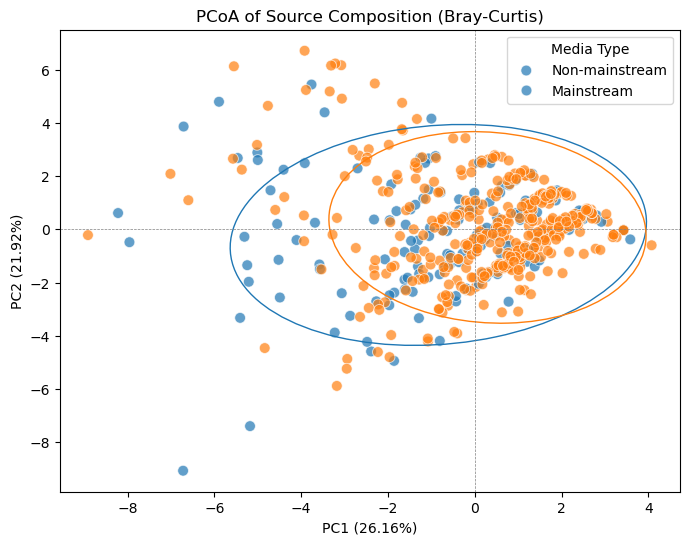

In [92]:
import numpy as np
import matplotlib.patches as mpatches

def draw_confidence_ellipse(x, y, ax, n_std=2.0, edgecolor='black', **kwargs):
    """
    繪製 95% 信賴橢圓
    """
    if x.size != y.size:
        raise ValueError("x 和 y 長度不同")

    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)

    # 計算特徵值和特徵向量
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # 橢圓參數
    theta = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigvals)

    ellipse = mpatches.Ellipse((mean_x, mean_y), width, height,
                               angle=theta, edgecolor=edgecolor, fill=False, **kwargs)
    ax.add_patch(ellipse)

# -----------------------------
# 修改繪圖程式
# -----------------------------
plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    x=pc['PC1'], y=pc['PC2'],
    hue=pc['group'],
    palette={'1':'#1f77b4','0':'#ff7f0e'},
    alpha=0.7, s=60
)

# 繪製 95% 橢圓
for g, color in zip(['1','0'], ['#1f77b4','#ff7f0e']):
    sub = pc[pc['group'] == g]
    draw_confidence_ellipse(sub['PC1'].values, sub['PC2'].values, plt.gca(), 
                            n_std=2.0, edgecolor=color)

plt.title("PCoA of Source Composition (Bray-Curtis)")
plt.xlabel(f"PC1 ({ordination.proportion_explained.iloc[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({ordination.proportion_explained.iloc[1]*100:.2f}%)")
plt.legend(title="Media Type", labels=["Non-mainstream","Mainstream"])
plt.axhline(0, color='grey', lw=0.5, ls="--")
plt.axvline(0, color='grey', lw=0.5, ls="--")
plt.show()

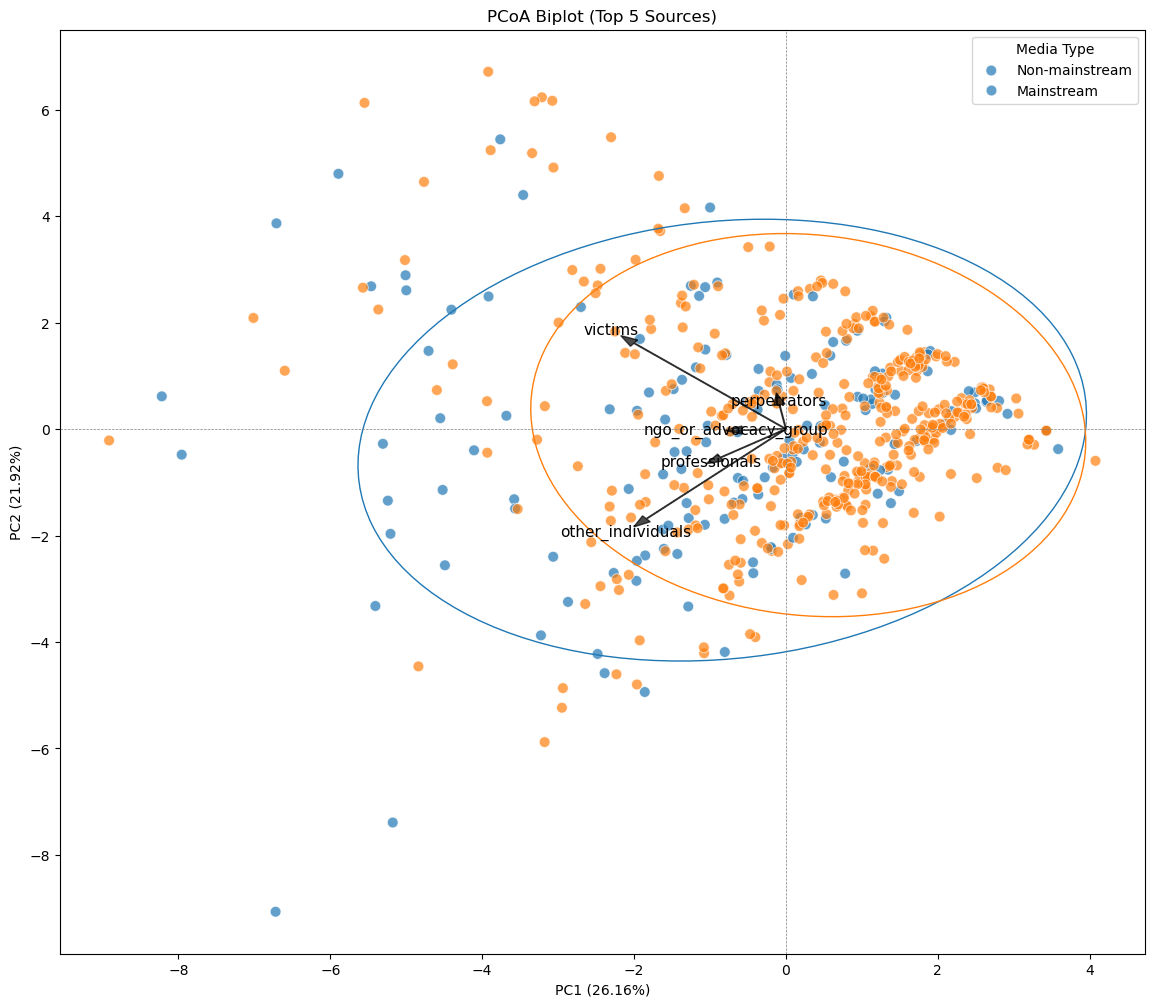

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 算出箭頭長度（貢獻度大小）
arrow_lengths = np.sqrt(np.sum(loadings**2, axis=1))  # 每個來源的向量長度
top_idx = np.argsort(arrow_lengths)[-5:]              # 取前 5 大

# 繪圖
plt.figure(figsize=(14,12))
ax = sns.scatterplot(
    x=pc['PC1'], y=pc['PC2'],
    hue=pc['group'],
    palette={'1':'#1f77b4','0':'#ff7f0e'},
    alpha=0.7, s=60
)

# 縮放箭頭
scales = 2.0 * loadings / np.max(np.abs(loadings))

for i in top_idx:
    ax.arrow(0, 0, scales[i,0], scales[i,1],
             color='black', alpha=0.7, width=0.01, head_width=0.15)
    ax.text(scales[i,0]*1.15, scales[i,1]*1.15, source_type_cols[i],
            fontsize=11, ha='center', va='center')

# 繪製 95% 橢圓
for g, color in zip(['1','0'], ['#1f77b4','#ff7f0e']):
    sub = pc[pc['group'] == g]
    draw_confidence_ellipse(sub['PC1'].values, sub['PC2'].values, plt.gca(), 
                            n_std=2.0, edgecolor=color)

plt.title("PCoA Biplot (Top 5 Sources)")
plt.xlabel(f"PC1 ({ordination.proportion_explained.iloc[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({ordination.proportion_explained.iloc[1]*100:.2f}%)")
plt.legend(title="Media Type", labels=["Non-mainstream","Mainstream"])
plt.axhline(0, color='grey', lw=0.5, ls="--")
plt.axvline(0, color='grey', lw=0.5, ls="--")
plt.show()

### Mantel test（比較距離矩陣相似度）

In [123]:
from skbio.stats.distance import mantel

# 建立兩種距離矩陣
dist_euclidean = squareform(pdist(X, metric='euclidean'))
dist_braycurtis = squareform(pdist(X, metric='braycurtis'))

dm_euc = DistanceMatrix(dist_euclidean, ids=df['article_id'])
dm_bray = DistanceMatrix(dist_braycurtis, ids=df['article_id'])

# Mantel test
mantel_res = mantel(dm_euc, dm_bray, permutations=999)
print("Mantel test:", mantel_res)

Mantel test: (0.5352787727700229, 0.001, 579)


### Procrustes analysis（比較 PCoA 排序結果的重合度）

In [133]:
from scipy.spatial import procrustes
from skbio.stats.ordination import pcoa

# PCoA on Euclidean
ordination_euc = pcoa(dm_euc)
# PCoA on Bray-Curtis
ordination_bray = pcoa(dm_bray)

# 取前幾個軸 (避免維度太高)
X1 = ordination_euc.samples.values[:, :2]
X2 = ordination_bray.samples.values[:, :2]

mtx1, mtx2, disparity = procrustes(X1, X2)

print("Procrustes disparity:", disparity)

Procrustes disparity: 0.7141701203959219


### 多樣性指標（Shannon entropy）

In [129]:
from scipy.stats import entropy

# 計算每篇文章的 Shannon entropy
df['shannon_entropy'] = df[source_type_cols].apply(
    lambda row: entropy(row.values, base=2), axis=1
)

# 比較主流 vs 非主流
main_entropy = df[df['mainstream']==1]['shannon_entropy']
nonmain_entropy = df[df['mainstream']==0]['shannon_entropy']

print("Mainstream mean entropy:", main_entropy.mean())
print("Non-mainstream mean entropy:", nonmain_entropy.mean())

# 檢定差異
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(main_entropy, nonmain_entropy)
print("Mann-Whitney U (entropy):", stat, p)

Mainstream mean entropy: 2.161231720389061
Non-mainstream mean entropy: 2.0990772159982547
Mann-Whitney U (entropy): 34054.5 0.2866590032320149


/var/folders/x7/dvs76fs53jq8n9z05g4ybf1w0000gn/T/ipykernel_58461/3664951167.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


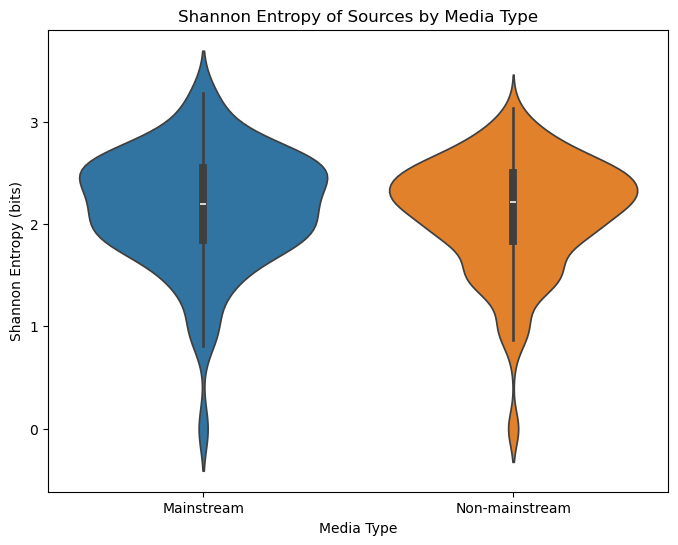

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.violinplot(
    x=df['mainstream'].map({1:'Mainstream', 0:'Non-mainstream'}),
    y=df['shannon_entropy'],
    palette={'Mainstream':'#1f77b4','Non-mainstream':'#ff7f0e'},
    inner='box'  # 在小提琴裡加 boxplot
)

plt.title("Shannon Entropy of Sources by Media Type")
plt.xlabel("Media Type")
plt.ylabel("Shannon Entropy (bits)")
plt.show()